# Apply PCA on all deployments data

In [1]:
import numpy as np
from itertools import permutations
import random
import os
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd
from os import makedirs
from datetime import datetime
from collections import Counter

from math import floor

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

# from MulticoreTSNE import MulticoreTSNE as TSNE
# from sklearn.manifold import TSNE
import seaborn as sns

from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Conv2D, Lambda, Flatten, MaxPooling2D, Concatenate, LSTM, Reshape, Lambda, ConvLSTM2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers.schedules import ExponentialDecay, PiecewiseConstantDecay
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy  # CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import tensorflow_addons.layers.spatial_pyramid_pooling as spp
# import tensorflow_datasets as tfds
from tensorflow.math import l2_normalize

import tensorflow as tf

In [2]:
import os
import numpy as np
import librosa
import tensorflow as tf

In [3]:
from math import floor
from lib_augment import load_and_normalize
from lib_feature import feature_whistleness

%matplotlib inline
import matplotlib.pyplot as plt


In [4]:
# deploy_path = '/home/ys587/__Data/__whistle/__whislte_30_species/__sound_48k/__whistle_oswald/STAR2000_48kHz'
species_dict = {'BD': 0, 'CD': 1, 'STR': 2, 'SPT': 3, 'SPIN': 4, 'PLT': 5, 'RT': 6,  'FKW': 7}
species_dict_inv = {0: 'BD', 1: 'CD', 2: 'STR', 3: 'SPT', 4: 'SPIN', 5: 'PLT', 6: 'RT', 7: 'FKW'}
fs = 48000
time_reso = 0.02
hop_length = int(time_reso*fs)  #
species_list = list(species_dict.keys())
species_id = list(species_dict.values())
num_species = len(species_dict)

In [5]:
species_to_code = {'bottlenose': 'BD', 'longbeaked_common': 'CD', 'shortbeaked_common': 'CD', 'common': 'CD',
                   'striped': 'STR', 'spotted': 'SPT', 'spinner': 'SPIN', 'pilot': 'PLT', 'roughtoothed': 'RT',
                   'false_killer': 'FKW'}

In [6]:
step_sec = 1.0  # sec
whistle_ratio = 0.2  # percentage of whislteness frames in a long window
# step_size = int(1.0*fs)
win_long_sec = 10   # 10 sec
step_ind = int(win_long_sec/step_sec)
step_size = int(step_sec*fs)
win_size = int(2.0*fs)

In [7]:
ten_sec_path = '/home/ys587/__Data/__whistle/__whislte_30_species/__dataset/ten_seconds_data'

In [8]:
# Hyper parameters
learning_rate = 1.0e-3
drop_rate = 0.2
hidden_units = 256
fcn_dim = 256

num_epoch = 200
# batch_size = 128
# batch_size = 32  # for cnn14+attention
batch_size = 16  # for cnn14+spp

num_patience = 5

In [9]:
# data_type_dict = {1: 'universal', 2: 'file', 3: 'encounter', 4: 'domain'}
# data_type = 2

work_path = '/home/ys587/__Data/__whistle/__whislte_30_species'
fit_result_path =  os.path.join(work_path, '__fit_result_species')
# feature_path = os.path.join(work_path, '__feature_species')
feature_path = os.path.join(work_path, '__dataset/20210210')

In [10]:
from datetime import datetime
today = datetime.now()
# create a folder based on date & time
fit_result_path1 = os.path.join(fit_result_path, today.strftime('%Y%m%d_%H%M%S'))

In [11]:
ee = 'STAR2000'
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    os.makedirs(fit_result_path2)

## Load features - test only

In [26]:
data_file = ['STAR2000_48kHz.npz', 'STAR2003_48kHz.npz', 'STAR2006_48kHz.npz', 'HICEAS2002_48kHz.npz', 'PICEAS2005_48kHz.npz']

feature = []
label_species = []
label_deploy = []
for dd0 in range(len(data_file)):
    dd = data_file[dd0]
    print(dd)
    feature_curr = np.load(os.path.join(ten_sec_path, dd))
    feature.append(feature_curr['feature_test'])
    label_species_curr = feature_curr['label_test']
    label_species.append(label_species_curr)
    label_deploy.append([dd0]*len(label_species_curr))
    del feature_curr

STAR2000_48kHz.npz
STAR2003_48kHz.npz
STAR2006_48kHz.npz
HICEAS2002_48kHz.npz
PICEAS2005_48kHz.npz


# reshape & merge

In [27]:
print(feature[0].shape)
feature = np.concatenate(feature)

(1542, 10, 100, 128, 1)


In [28]:
print(feature.shape)
num_data, num_win, num_time, num_freq, num_chan = feature.shape

feature = feature.reshape(-1, 10*100*128)

(5803, 10, 100, 128, 1)


In [29]:
print(feature.shape)

(5803, 128000)


In [30]:
# label species
label_species = np.concatenate(label_species)

In [31]:
label_species_id = np.zeros(label_species.shape[0])
for ii in range(len(label_species)):
    label_species_id[ii] = species_dict[label_species[ii]]
label_species_id = label_species_id.astype(int)

In [32]:
# label deployment
label_deploy = np.concatenate(label_deploy)

# PCA

In [33]:
feature.shape

(5803, 128000)

In [40]:
feature_nomean = feature - feature.mean(axis=0)

In [41]:
U, Sigma, VT = np.linalg.svd(feature_nomean, full_matrices=False)

In [42]:
# sanity check
print("Feature: ", feature.shape)
print("U: ", U.shape)
print("Sigma: ", Sigma.shape)
print("VT: ", VT.shape)

Feature:  (5803, 128000)
U:  (5803, 5803)
Sigma:  (5803,)
VT:  (5803, 128000)


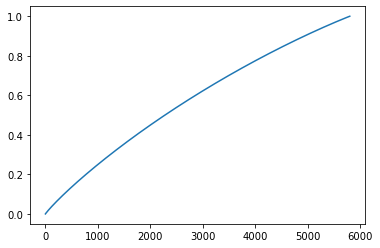

In [43]:
plt.plot(np.cumsum(Sigma)/Sigma.sum())

In [45]:
num_components = 4000
Y = np.matmul(feature_nomean, VT[:num_components].T)

In [46]:
import seaborn as sns

In [48]:
df = pd.DataFrame({'Y1': Y[:, 0], 'Y2': Y[:, 1], 'label_species': label_species, 'label_deploy': label_deploy})

In [79]:
df['species_id'] = df['label_species'].apply(lambda x: species_dict[x])

In [91]:
# df['size'] = df['species_id'].apply(lambda x: float(x)*.2)
df['size'] = 0.2

In [92]:
df.sample(5)

,Y1,Y2,label_species,label_deploy,species_id,size
853,-2.121841,-0.315356,CD,0,1,0.2
2957,6.772488,0.599455,STR,2,2,0.2
2307,3.900937,-0.256981,FKW,2,7,0.2
5486,-1.233419,-2.437820,SPT,4,3,0.2
3744,-0.200926,1.678100,SPT,3,3,0.2


In [110]:
palette = sns.set_palette("dark")

<AxesSubplot:xlabel='Y1', ylabel='Y2'>

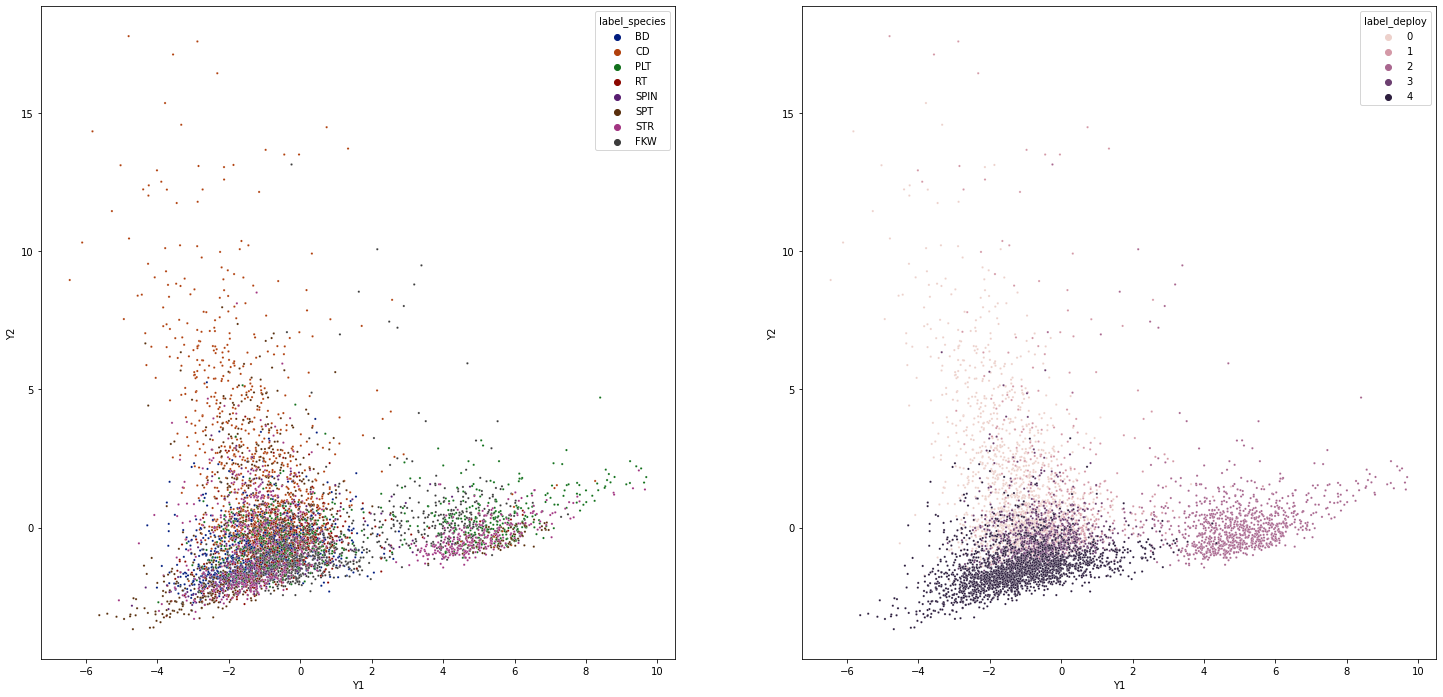

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
sns.scatterplot(data=df, x='Y1', y='Y2', hue='label_species', ax=ax1, palette=palette, s=5)
sns.scatterplot(data=df, x='Y1', y='Y2', hue='label_deploy', ax=ax2, palette=palette, s=5)

In [116]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [117]:
projection = TSNE(n_jobs=7).fit_transform(Y)

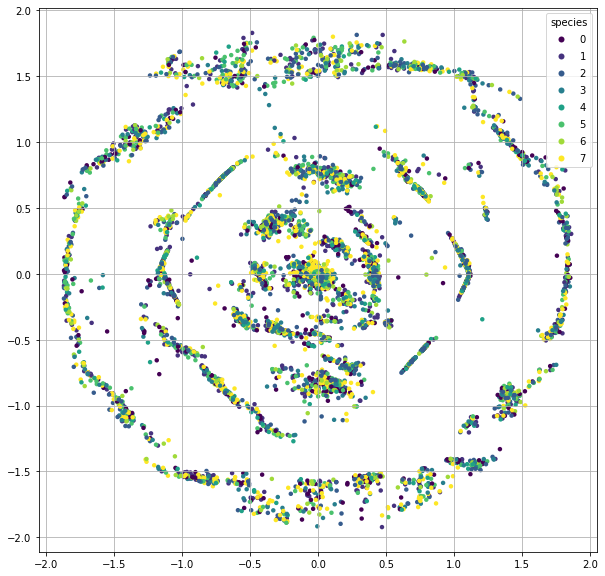

In [121]:
label_species_id = [species_dict[x]
    for x in label_species]

plt.figure(figsize=(10, 10))
# plt.scatter(*projection.T)
scatter = plt.scatter(projection.T[0, :], projection.T[1, :], s=20, linewidth=0, c=label_species_id)  # , alpha=0.25
plt.legend(*scatter.legend_elements(), title='species')
plt.grid()

In [125]:
projection2 = TSNE(n_jobs=7, perplexity=5).fit_transform(Y)

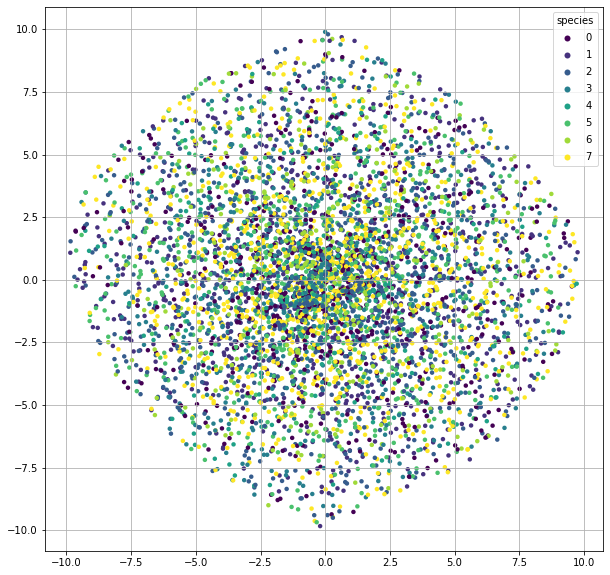

In [126]:
plt.figure(figsize=(10, 10))
# plt.scatter(*projection.T)
scatter = plt.scatter(projection2.T[0, :], projection2.T[1, :], s=20, linewidth=0, c=label_species_id)  # , alpha=0.25
plt.legend(*scatter.legend_elements(), title='species')
plt.grid()

In [127]:
import umap
trans = umap.UMAP(n_neighbors=10, random_state=42).fit(Y)

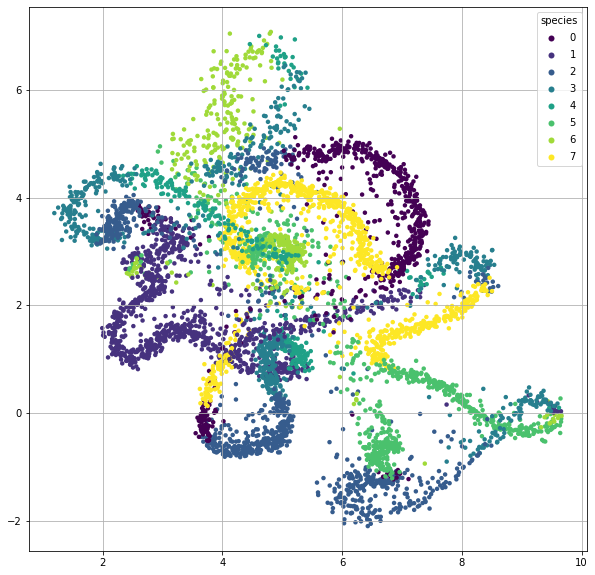

In [128]:
plt.figure(figsize=(10, 10))
scatter = plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s=20, linewidth=0, c=label_species_id)  # , alpha=0.25
plt.legend(*scatter.legend_elements(), title='species')
plt.grid()

In [129]:
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(Y)

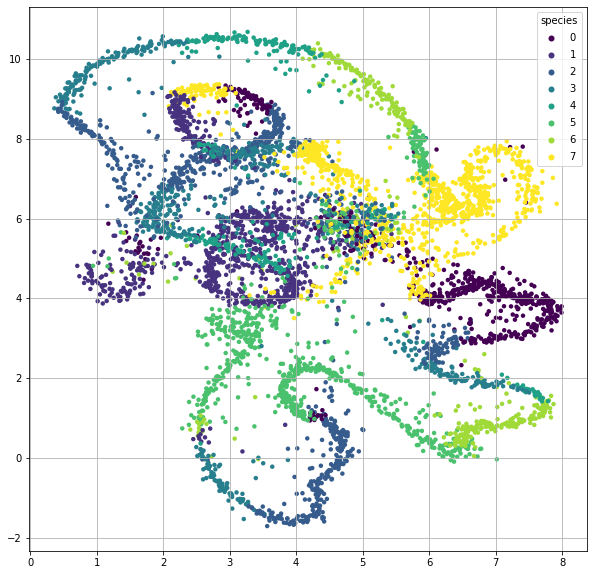

In [130]:
plt.figure(figsize=(10, 10))
scatter = plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s=20, linewidth=0, c=label_species_id)  # , alpha=0.25
plt.legend(*scatter.legend_elements(), title='species')
plt.grid()

In [131]:
trans = umap.UMAP(n_neighbors=30, random_state=42).fit(Y)

## species labels

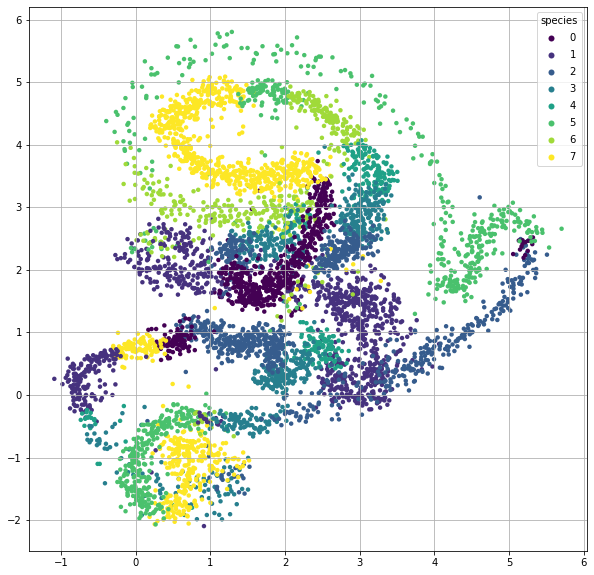

In [132]:
plt.figure(figsize=(10, 10))
scatter = plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s=20, linewidth=0, c=label_species_id)  # , alpha=0.25
plt.legend(*scatter.legend_elements(), title='species')
plt.grid()

## deployment labels

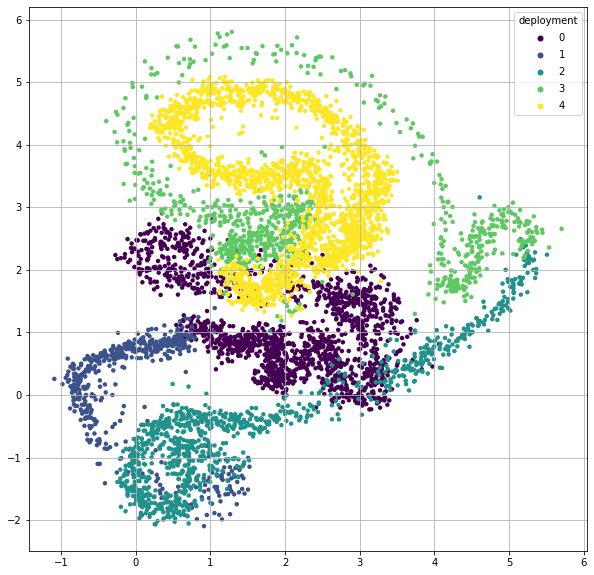

In [136]:
plt.figure(figsize=(10, 10))
scatter = plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s=20, linewidth=0, c=label_deploy)  # , alpha=0.25
plt.legend(*scatter.legend_elements(), title='deployment')
plt.grid()

## Autoencoder